In [8]:
from dataloader.dataloader import DatasetLoader

from functions.calculate_mse_psnr import calculate_mse_psnr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import copy
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau


from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

import os
import scipy.io
from tqdm import tqdm
from models.CSModelPlus import CSAutoencoderPlus

In [9]:
device = "cpu"
transform = transforms.Compose([ # Ajusta al tamaño deseado
    transforms.ToTensor()
])
model = CSAutoencoderPlus(input_size=409,output_size=4096).to(device)
model.load_state_dict(torch.load("./train_results/Kernel_64_CSAE_aug/50000_0.0001_1000_0.8/best_model.pth"))
model.eval()

CSAutoencoderPlus(
  (encoder): CSEncoderPlus(
    (layer1): Linear(in_features=4096, out_features=818, bias=True)
    (layer2): Linear(in_features=818, out_features=818, bias=True)
    (layer3): Linear(in_features=818, out_features=409, bias=True)
  )
  (decoder): CSDecoderPlus(
    (layer1): Linear(in_features=409, out_features=8192, bias=True)
    (layer2): Linear(in_features=8192, out_features=8192, bias=True)
    (layer3): Linear(in_features=8192, out_features=8192, bias=True)
    (layer4): Linear(in_features=8192, out_features=4096, bias=True)
  )
)

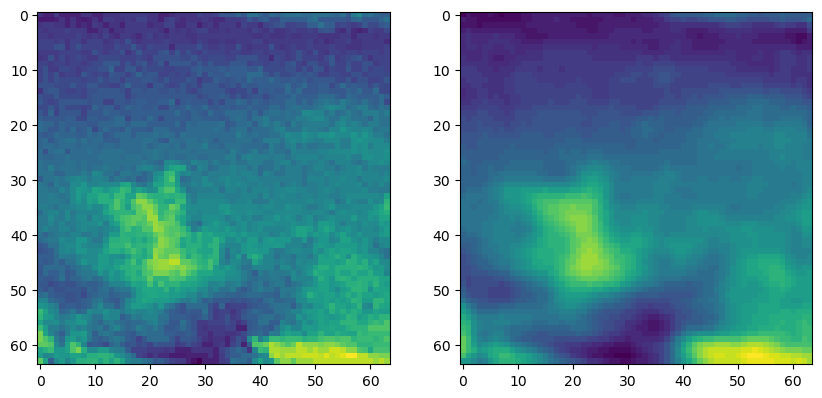

In [10]:
im = Image.open("dataset/parches64/1_parche_30.png").convert("L")
imt = transform(im).to(device).view(-1)
with torch.no_grad():
    imt_rec = np.array(model(imt).squeeze().cpu())
imt_rec = (imt_rec * 255).reshape(64,64).astype(np.uint8)
imt_rec = Image.fromarray(imt_rec)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(im)

plt.subplot(1,2,2)
plt.imshow(imt_rec)
plt.show()

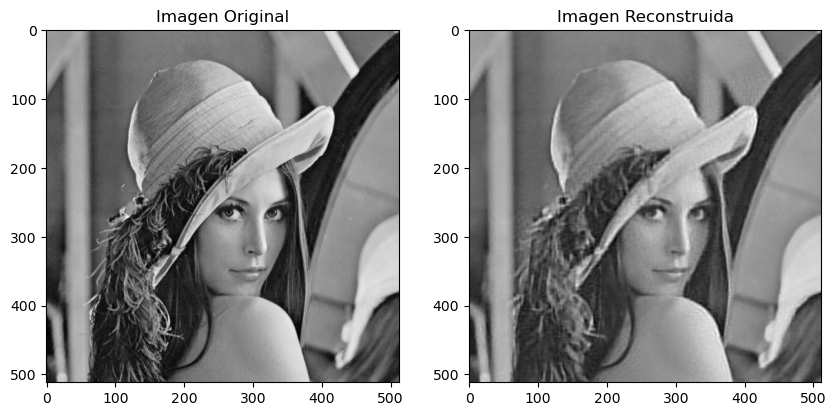

MSE : 70.86300277709961 || PSNR : 29.626608095135076


In [12]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch

# Suponiendo que CSMatrix es un tensor PyTorch de dimensiones [1, 4096]
# y que 'device' y 'model' están definidos correctamente

# Cargar y convertir la imagen a escala de grises
imageOG = Image.open("dataset/standard_Images/Lenna.png").convert("L")

# Transformar la imagen
transform = transforms.Compose([
    transforms.ToTensor(),
    # Añade aquí cualquier otra transformación necesaria
])
image = transform(imageOG)

# Preparar para procesar la imagen por parches
patch_size = 64
num_patches_height = image.shape[1] // patch_size
num_patches_width = image.shape[2] // patch_size
reconstructed_image = torch.zeros((patch_size * num_patches_height, patch_size * num_patches_width))
all_inputs = []  # Lista para almacenar todas las multiplicaciones matriciales

# Procesar cada parche
for i in range(num_patches_height):
    for j in range(num_patches_width):
        # Extraer el parche
        patch = image[:, i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
        patch = patch.to(device).reshape(1, -1)

        # Multiplicación matricial
        input = patch

        # Añadir el resultado a la lista
        all_inputs.append(input)

        # Pasar por el modelo
        with torch.no_grad():
            model.eval()
            patch_rec = model(input).cpu().squeeze()

        # Reconstruir el parche en la imagen
        reconstructed_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patch_rec.reshape(patch_size, patch_size)

# Convertir la lista all_inputs en un tensor
all_inputs_tensor = torch.stack(all_inputs)

# Convertir a imagen para visualización
reconstructed_image = (reconstructed_image * 255.0).clamp(0, 255).numpy().astype(np.uint8)
reconstructed_image = Image.fromarray(reconstructed_image)

# Visualización
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(imageOG, cmap='gray')
plt.title('Imagen Original')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Imagen Reconstruida')

plt.show()

mse,psnr = calculate_mse_psnr(imageOG,reconstructed_image)
print(f"MSE : {mse} || PSNR : {psnr}")